In [1]:
%matplotlib inline

In [2]:
! pip install -q gdown

In [3]:
import os
import time
import torch
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn.metrics

from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
debug = False
scale_factor = 100

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# Data loader

In [6]:
def to_feats_labels_dates(df, label_column='label', dtype=np.float64):
    '''
    Splits df into a tuple: 
    (ndarray of features, ndarray of labels, ndarray of dates)
    '''
    features = df.drop(columns=label_column).to_numpy(dtype=dtype)
    # if features are a set of 1D vectors we have to change it into
    # a set of matrices with only one row (1 channel)
    if len(features.shape) == 2:
        features = np.expand_dims(features, axis=1)
    labels = df[label_column].to_numpy(dtype=dtype)
    labels = np.expand_dims(labels, axis=1)
    dates = df.index.to_numpy()
    return features, labels, dates

In [7]:
def split_df_in_order(df, train_size, valid_size, test_size):
    '''
    Splits dataframe into train, valid and test size in sequential order.
    Args:
    df: dataframe to do a split on
    train_size, valid_size, test_size: fractions that have to sum up to 1
    Returns:
    tuple (train set, valid set, test set)
    '''
    if train_size + valid_size + test_size != 1.0:
        raise ValueError('Sizes do not sum up to 1')

    train_size = int(train_size * len(df))
    valid_size = int(valid_size * len(df) + train_size)
    return np.split(df, [train_size, valid_size])

In [8]:
class DataLoader():
    '''
    A torch dataloader that fetches data from memory
    and divides it into batches. Uses torch.utils.dataDataLoader. 
    '''
    def __init__(self,
                 batch_size, 
                 dataset, 
                 labels,
                 dates = None,
                 shuffle=True, 
                 drop_last=False,
                 device='cuda'):
        self.dataset = torch.utils.data.TensorDataset(
            torch.tensor(dataset, dtype=torch.float64, device=device),
            torch.tensor(labels, dtype=torch.float64, device=device)
        )
        self.data_loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=shuffle, 
            drop_last=drop_last
        )
        self.dates = dates
        self.iter_with_dates = False

    def __iter__(self):
        if self.iter_with_dates:
            self.iter_with_dates = False
            date_index = 0
            for batch in self.data_loader:
                date = self.dates[date_index]
                date_index += len(batch[0])
                yield batch, date
        else:
            for batch in self.data_loader:
                yield batch

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

    def get_all(self):
        '''
        Returns tuple of torch.tensors (all data samples, all labels)
        '''
        return self.dataset.tensors[0], self.dataset.tensors[1]

    def get_dates(self):
        '''
        Returns numpy array with dates that match the dataset
        '''
        if self.dates is not None:
            return self.dates

    def call(iter_with_dates=False):
        self.iter_with_dates=True
        return self

# Training loop

In [9]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.title("Loss history")
    plt.plot(history['train_losses'], label="Train loss")
    plt.xlabel("Batch")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Validation loss")
    plt.plot(history['val_losses'])
    plt.xlabel("Epoch")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Validation Performance")
    plt.plot(history['val_ic'], label="Information coefficient")
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Validation Good Predictions in %")
    plt.plot(history['val_good_preds'], label="Accurate price change dir prediction")
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

In [10]:
def compute_loss(model, data_loader, device="cpu"):
    '''
    Evaluate the model on all samples
    Returns:
    (information coefficient, 
    p value, 
    loss, predicted y,
    percent of predictions with correct direction of the change)
    '''
    model.eval()
    model.to(device)
    with torch.no_grad():
        if isinstance(data_loader, DataLoader):
            data_loader.to(device)
        x, y_true = data_loader.get_all()
        with torch.no_grad():
            y_preds = model.forward(x)
        ic, p_val = spearmanr(y_preds.cpu(), y_true.cpu())
        loss = model.loss(y_preds, y_true)
        accurate_direction_pred = np.sum(
            (np.array(y_preds.cpu()) * 1e10 * np.array(y_true.cpu())) > 0
        )/len(y_true)
    return ic, p_val, loss, y_preds, accurate_direction_pred

In [11]:
def train(model,
          optimizer, 
          data_loaders, 
          max_num_epochs,
          device='cpu',
          log_every=10,
          early_stopping=10):
    model.train()
    model.to(device)

    for data_loader in data_loaders.values():
        if isinstance(data_loader, DataLoader):
            data_loader.to(device)

    num_epochs = max_num_epochs
    iter_ = 0
    epoch = 0
    stop = 0
    best_params = None
    best_ic = -np.inf
    history = {"train_losses": [], "val_ic": [], "val_p_val": [],
               "val_losses": [], "val_good_preds": []}
    loss_hist = []
    tstart = time.time()
    while epoch < num_epochs:
        model.train()
        epoch += 1
        if epoch > max_num_epochs:
            break
        for x, y in data_loaders['train']:
            x = x.to(device)
            y = y.to(device)
            iter_ += 1
            out = model(x)
            loss = model.loss(out, y)
            # print(out[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iter_ % log_every == 0:
                num_iter = iter_ + 1
                print(
                    "Minibatch {0: >6}  |  loss {1: >5.8f}  |  steps/s {2: >5.2f}  |  Epoch {3: >4}".format(
                        iter_,
                        loss.item(),
                        num_iter / (time.time() - tstart),
                        epoch
                    )
                )
            history["train_losses"].append(loss.item())
            
        clear_output(True)
        ic, p_val, loss, _, good_dir_preds = compute_loss(model, data_loaders["valid"], device)
        history["val_losses"].append(loss)
        history["val_ic"].append(ic)
        history["val_p_val"].append(p_val)
        history["val_good_preds"].append(good_dir_preds)
        if ic > best_ic:
            stop = 0
            best_epoch = epoch
            best_ic = ic
            best_params = [p.detach().cpu() for p in model.parameters()]
        else:
            stop += 1
        if stop == early_stopping:
            break

        print(
            "After epoch {0: >2}  |  IC {1: >6.8f}  |  p value {2: <6.8f}  |  loss {3: <6.8f}  | No progress for: {4: >2} epochs  |  Good preds: {5: >2.3f}%".format(
                epoch, ic, p_val, loss, stop, good_dir_preds
            )
        )

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
                
    print("Max/Min train loss: {:.9f}/{:.9f}".format(np.max(history['train_losses']), np.min(history['train_losses'])))
    print("First few train losses:", history['train_losses'][:3])
    return history

# 1D ConvNet

## Downloading the data and processing it into lagged returns

Our 1D model is given a vector of 1-minute lagged returns (price change compared to the last minute) for the last 20 minutes and has to predict the price change for the next minute. 

In [12]:
raw_2020_csv_url = "https://drive.google.com/uc?id=1P9en855X9FFlW-dOH93mQNuYE3P4Lvgy"
parsed_2020_csv_url = "https://drive.google.com/uc?id=1-2WjRhXyaDen-yubN6XcJ_P-QQIFBec6"
raw_2019_csv_url = "https://drive.google.com/uc?id=1eK7jh5pxLStH_IQ7B25WuckAUMjRz5T6"
parsed_2019_5min_csv_url = "https://drive.google.com/uc?id=1-1GAt_03q3pG7lSpobqyU9cx9yRAoBew"
raw_2020_eth_csv_url = "https://drive.google.com/uc?id=1ie5klmDRnXC9KwvEn-BQTkDRJJxEAxa-"
btc_model1d_url = "https://drive.google.com/uc?id=1d26M9ONgyfCT6LRfLvvW4kt5pjD0Sj_D"
btc_model2d_by_ic_url = "https://drive.google.com/uc?id=1lqu15TubWkGzn1bjoWeZZemfCvE_FBPq"

In [13]:
def clean_parsed_df(df):
    '''
    Used if a preproccessed df with lagged returns has been saved 
    to a csv file and that file is loaded into a df passed as an argument. 
    This function a quick clean of that df, bringing it to a original, 
    preproccessed form. 
    df should have columns:
        'date' which will be used as a index
        'label' which is the true value 
        columns 1,2,...,N which are the lagged returns
    Returns:
        DataFrame
    '''
    df = df.set_index(pd.to_datetime(df['date'])).drop(columns=['date'])
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

In [14]:
def load_data(path):
    '''
    df input columns:
        time;open;close;high;low;vol;dt
    df output columns:
        time       int64
        open     float64
        close    float64
        high     float64
        low      float64
        vol      float64
    df output index:
        dt    datetime64
    '''
    df = pd.read_csv(path)
    df = df.set_index(pd.DatetimeIndex(df['dt'])).drop(['dt'], axis=1)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

In [15]:
def lagged_returns(df, interval='M', nlags=20):
        
    df = df['close'].to_frame()
    
    returns = (df
          .resample(interval)
          .last()
          .pct_change()
          .dropna(how='all')
          .dropna(axis=1)
          .sort_index(ascending=False))
    
    n = len(returns)
    lags = list(range(1, nlags + 1))
    cnn_data = []
    for i in tqdm(range(n-nlags-1)):
        df = returns.iloc[i:i+nlags+1] # select outcome and lags
        date = df.index.max() # use outcome date
        cnn_data.append(df.reset_index(drop=True) # append transposed series
        .transpose()
        .assign(date=date)
        .set_index('date', append=True)
        .sort_index(1, ascending=True))


    cnn_data = (pd.concat(cnn_data)
     .rename(columns={0: 'label'})
     .sort_index())
    
    return cnn_data

In [16]:
def load_process_save(url, file_name, dest_path, interval='M', nlags=20):
    '''
    Downloads a file with prices from 'url' and saves it to 'file_name'.
    Then, processess the file to a dataframe of lagged returns with interval 
    given by the 'interval' parameter and number of lags given by the 'nlags'.
    Saves the file to the Google Drive (requires authorization) at 'dest_path'
    Returns the tuple of (raw dataframe, df processed into lagged returns)
    '''
    # Getting the prices and processing them into a df
    gdown.download(url, file_name, quiet=False)
    raw_df = load_data(file_name)

    # Processing the dataframe to dataframe of lagged returns from a given interval
    lagged_df= lagged_returns(raw_df, interval=interval, nlags=nlags)

    # Saving the lagged returns DataFrame to the Google Drive, so that it won't be
    # necessary to do the long preprocessing every time we restart the colab
    drive.mount('/drive')
    lagged_df.to_csv(dest_path)
    return raw_df, lagged_df

In [17]:
# Loading the csv with lagged returns from from Google Drive and process it into
# a df with proper columns and index (since saving df to csv messes up indexes)
gdown.download(parsed_2020_csv_url, "btc_2020_1M.csv", quiet=False)
btc_2020_1M_20int = clean_parsed_df(pd.read_csv("btc_2020_1M.csv"))

Downloading...
From: https://drive.google.com/uc?id=1-2WjRhXyaDen-yubN6XcJ_P-QQIFBec6
To: /content/btc_2020_1M.csv
261MB [00:01, 217MB/s]


In [18]:
# Have to scale up the lagged returns to represent change in percentage.
# Keeping the returns as a fraction makes a net train poorly, probably because
# of very small values (float precision messes things up?)
btc_scaled = btc_2020_1M_20int * scale_factor
btc_scaled.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01 01:22:00,0.002110,0.050765,0.004644,0.003589,-0.018573,-0.010868,-0.007491,-0.034701,0.008439,-0.039435,-0.009173,-0.026878,-0.020971,0.017391,-0.066358,-0.024536,0.014007,0.007478,-0.013164,0.015799,-0.062737
2020-06-01 01:23:00,0.043987,0.002110,0.050765,0.004644,0.003589,-0.018573,-0.010868,-0.007491,-0.034701,0.008439,-0.039435,-0.009173,-0.026878,-0.020971,0.017391,-0.066358,-0.024536,0.014007,0.007478,-0.013164,0.015799
2020-06-01 01:24:00,-0.009595,0.043987,0.002110,0.050765,0.004644,0.003589,-0.018573,-0.010868,-0.007491,-0.034701,0.008439,-0.039435,-0.009173,-0.026878,-0.020971,0.017391,-0.066358,-0.024536,0.014007,0.007478,-0.013164
2020-06-01 01:25:00,0.060528,-0.009595,0.043987,0.002110,0.050765,0.004644,0.003589,-0.018573,-0.010868,-0.007491,-0.034701,0.008439,-0.039435,-0.009173,-0.026878,-0.020971,0.017391,-0.066358,-0.024536,0.014007,0.007478
2020-06-01 01:26:00,0.010539,0.060528,-0.009595,0.043987,0.002110,0.050765,0.004644,0.003589,-0.018573,-0.010868,-0.007491,-0.034701,0.008439,-0.039435,-0.009173,-0.026878,-0.020971,0.017391,-0.066358,-0.024536,0.014007


In [19]:
_train, _valid, _test = split_df_in_order(btc_scaled, 0.7, 0.1, 0.2)
batch_size = 1000

btc_loaders = {
    'train': DataLoader(batch_size, *to_feats_labels_dates(_train), shuffle=True, device=device),
    'valid': DataLoader(batch_size, *to_feats_labels_dates(_valid), shuffle=False, device=device),
    'test': DataLoader(batch_size, *to_feats_labels_dates(_test), shuffle=False, device=device)
}

## Architecture


In [20]:
class Conv1D(nn.Module):
    def __init__(self,
                 in_size, 
                 out_channels=32, 
                 kernel_size=5, 
                 pool_size=2,
                 maxpool_padding=0,
                 loss_fun=torch.nn.MSELoss(),
                 dtype=torch.float64):
        super(Conv1D, self).__init__()
        
        self.conv_out = int((in_size - kernel_size + 1 + maxpool_padding) * out_channels / pool_size)
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size, padding=maxpool_padding),
            nn.Flatten()
            )
    
        self.linear = nn.Sequential(
            nn.Linear(self.conv_out, 1)
            )
        self.loss_fun = loss_fun
        self.to(dtype=dtype)

    def forward(self, X):
        X = self.conv(X)
        X = self.linear(X)
        return X

    def loss(self, out, targets):
        return self.loss_fun(out, targets)

## Training
We used SGD and Adam optimizers with different parameters. Eventually, the best model was trained by the SGD with learning rate of 0.009 and momentum of 0.95.

In [21]:
# btc_model1d = Conv1D(in_size=20)
# history = train(btc_model1d,
#                 torch.optim.SGD(btc_model1d.parameters(), lr=0.009, momentum=0.95),
#                 #torch.optim.Adam(btc_model1d.parameters(), lr=0.005),
#                 btc_loaders,
#                 max_num_epochs = 100,
#                 device='cuda',
#                 early_stopping=12)
# plot_history(history)

## Loading a pre-trained model

In [22]:
gdown.download(btc_model1d_url, "btc_model1d.pth", quiet=True)
btc_model1d = Conv1D(in_size=20)
if device == 'cpu':
    btc_model1d.load_state_dict(torch.load("btc_model1d.pth"), map_location=torch.device('cpu'))
else:
    btc_model1d.load_state_dict(torch.load("btc_model1d.pth"))

## Evaluation

In [23]:
ic, _, _, y_preds, acc_pred_count = compute_loss(btc_model1d, btc_loaders['test'])
_, y_true = btc_loaders['test'].get_all()
dates = btc_loaders['test'].get_dates()
print("IC for test set: {}\nCorrectly predicted directions of changes in prices: {:.5f}".format(ic, acc_pred_count * 100))

IC for test set: 0.1021192567102852
Correctly predicted directions of changes in prices: 51.59371


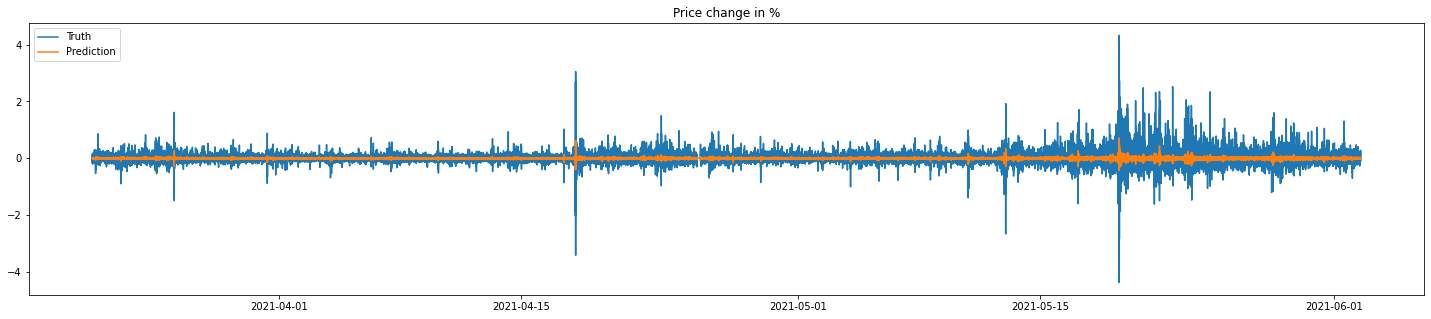

In [24]:
plt.figure(figsize=(25, 5))
plt.title("Price change in %")
plt.plot(dates, y_true, label="Truth")
plt.plot(dates, y_preds, label="Prediction")
plt.legend(loc="upper left")
plt.show()

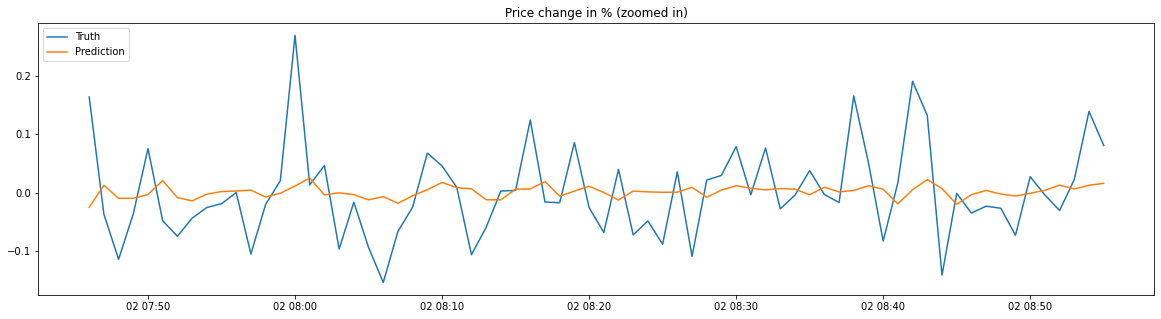

In [25]:
plt.figure(figsize=(20, 5))
plt.title("Price change in % (zoomed in)")
plt.plot(dates[-270:-200], y_true[-270:-200], label="Truth")
plt.plot(dates[-270:-200], (y_preds)[-270:-200], label="Prediction")
plt.legend(loc="upper left")
plt.show()

In [26]:
print("Predicted price changes bigger than 0.2%: {}/{}".
      format(len(y_preds[y_preds > 0.2]), len(y_preds)))

Predicted price changes bigger than 0.2%: 43/105540


In [27]:
print("True price changes bigger than 0.2%: {}/{}".
      format(len(y_true[y_true > 0.2]), len(y_true)))

True price changes bigger than 0.2%: 4828/105540


# 2D ConvNet
Since the price changes for 1 minute periods are mostly small, we decided to do predictions for the intervals of 5 minutes. This way, there is a higher probability that the price change will exceed the fee-related costs.

## Architecture
For our 2D model, we use two convolutional layers with ReLU activations, followed by MaxPooling and Dropout layers. At the end, we use two fully connected linear layers with ReLU and Dropout in between. 

In [28]:
class Conv2D(nn.Module):
    def __init__(self, 
                 size_x, 
                 size_y,
                 out1=16, 
                 out2=32, 
                 linear_out1=32,
                 no_channels=1,
                 drop_one=.25, 
                 drop_two=.5,
                 dtype=torch.float64,
                 kernel_size=(3, 3),
                 pooling_size=2,
                 loss_fun=torch.nn.MSELoss(),
                 conv_out=512):
        super(Conv2D, self).__init__()
        input_shape = (size_x, size_y, 1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=no_channels,
                out_channels=out1,
                kernel_size=kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=out1,
                out_channels=out2,        
                kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(pooling_size),
            nn.Dropout(drop_one),
            nn.Flatten())
      
        self.linear = nn.Sequential(
            nn.Linear(conv_out, linear_out1),
            nn.ReLU(),
            nn.Dropout(drop_two),
            nn.Linear(linear_out1, 1)
        )
        self.loss_fun = loss_fun
        self.to(dtype=dtype)

    def forward(self, X):
        X = self.conv(X)
        X = self.linear(X)
        return X

    def loss(self, out, targets):
        return self.loss_fun(out, targets)

## Predicting ETH price change every 5 minutes

Given the indicators from the last 15 5-minutes periods, we want to predict the price change of the ETH after 5 minutes. To do so, we arrange the indicators into a 2D grid and feed into into a convolutional network. 


In [29]:
def save_array(arr, path):
    if len(arr.shape) == 3:
        if arr.shape[1] == 15 and arr.shape[2] == 15:
            arr = arr.reshape(-1, 225)
    np.savetxt(path, arr, delimiter=',')


def compose_channels(l):
    '''Composing image-like numpy array from passed list of arrays'''

    bs = l[0].shape[0]
    dim = l[0].shape[-1]
    arr = np.zeros((bs, len(l), dim,  dim), dtype = np.float)
    for i in range(len(l)):
        arr[:, i, :, :] = l[i]
    return arr

def import_array(path, gdown_ = True, gdown_path = None):
    if gdown_:
        gdown.download(gdown_path, path, quiet=False)

    arr = np.genfromtxt(path, delimiter = ',')
    if len(arr.shape) == 2:
        arr = arr.reshape(-1,15,15)
    return arr

def reshape_for_scaling(X):
    return X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

def restore_og_shape(X, fst_axis, snd_axis):
    return X.reshape((X.shape[0], fst_axis, snd_axis))

### Model that takes 1 channel input (ETH indicators). 

#### Downloading the data

In [30]:
dates = pd.read_csv('https://drive.google.com/u/0/uc?id=18LOPHl2jcr5_RKjxzeyKta0oiqeHMIXE&export=download')['dt'].iloc[:-1]
#dates = np.expand_dims(dates.to_numpy(), 1)
dates_as_np = pd.to_datetime(dates).to_numpy()

In [31]:
url_eth_x = 'https://drive.google.com/u/0/uc?id=1-GRJ0aJcwPz9I_F3Y_-283MVy3CyFwHU&export=download'
eth_x = import_array('eth_x.csv', gdown_ = True, gdown_path = url_eth_x)

url_targets = 'https://drive.google.com/u/0/uc?id=1-HWzs80JJK3SIZywBLk1JS6lD_DCuG9I&export=download'
targets_eth_x = import_array('targets_eth_x.csv', gdown_ = True, gdown_path = url_targets)

Downloading...
From: https://drive.google.com/u/0/uc?id=1-GRJ0aJcwPz9I_F3Y_-283MVy3CyFwHU&export=download
To: /content/eth_x.csv
567MB [00:01, 285MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1-HWzs80JJK3SIZywBLk1JS6lD_DCuG9I&export=download
To: /content/targets_eth_x.csv
2.55MB [00:00, 174MB/s]


In [32]:
eth_prices = pd.read_csv('https://drive.google.com/u/0/uc?id=1i5h9rqk1L7aQ0qL3gah8TJDfLrxRIUlI&export=download').drop(columns = ['Unnamed: 0']).set_index('dt')

#### Scaling the data and preparing the data loader

In [33]:
# Calculating the sizes of train, valid and test sets
N = len(eth_x)
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1
train_size = int(train_frac * N)
valid_size = int(valid_frac * N + train_size)

y = targets_eth_x * 100
y = np.expand_dims(y, 1)
_train_X, _valid_X, _test_X = np.split(eth_x, [train_size, valid_size])
_train_y, _valid_y, _test_y = np.split(y, [train_size, valid_size])
_train_dates, _valid_dates, _test_dates = np.split(dates_as_np, [train_size, valid_size])

In [34]:
_train_X = reshape_for_scaling(_train_X)
_valid_X = reshape_for_scaling(_valid_X)
_test_X = reshape_for_scaling(_test_X)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X_train = scaler.fit_transform(_train_X)
scaled_X_valid = scaler.transform(_valid_X)
scaled_X_test = scaler.transform(_test_X)

_train_X = np.expand_dims(restore_og_shape(scaled_X_train, 15, 15), 1)
_valid_X = np.expand_dims(restore_og_shape(scaled_X_valid, 15, 15), 1)
_test_X = np.expand_dims(restore_og_shape(scaled_X_test, 15, 15), 1)

In [35]:
batch_size = 1000
grid_loaders_1channel = {
    'train': DataLoader(batch_size, _train_X, _train_y, _train_dates, shuffle=True, device=device),
    'valid': DataLoader(batch_size, _valid_X, _valid_y, _valid_dates, shuffle=False, device=device),
    'test': DataLoader(batch_size, _test_X, _test_y, _test_dates, shuffle=False, device=device)
}

In [36]:
grid_loaders_1channel['test'].get_all()[0].shape

torch.Size([9996, 1, 15, 15])

#### Training the model
To train the model, we used SGD. We experimented with different parameters: learning rate from ~0.01 to ~0.3, momentum from ~0.8 to ~0.97 or completely turned off. We did a few runs with Adam, but it didn't improve the training. 

In [37]:
# eth_model = Conv2D(15, 15, conv_out=800)
# history = train(eth_model,
#             torch.optim.SGD(eth_model.parameters(), 
#                             lr=0.02, 
#                             momentum=0.95),
#             # torch.optim.Adam(eth_model.parameters(), lr=0.1),
#             grid_loaders_1channel,
#             max_num_epochs=300,
#             device='cuda',
#             early_stopping=20)
# plot_history(history)

In [38]:
# torch.save(eth_model.state_dict(), "eth100k_08-01-01_1channel.pth")

#### Loading a pre-trained model

In [39]:
eth_model_url = 'https://drive.google.com/u/0/uc?id=1mA0ZFvSNWtYyASXSQE4rvDkYHeGJDJBh&export=download'

In [40]:
gdown.download(eth_model_url, "eth100k_08-01-01_1channel.pth", quiet=True)
model2d_single_channel = Conv2D(15, 15, conv_out=800)
if device == 'cpu':
    model2d_single_channel.load_state_dict(torch.load("eth100k_08-01-01_1channel.pth", map_location=torch.device('cpu')))
else:
    model2d_single_channel.load_state_dict(torch.load("eth100k_08-01-01_1channel.pth"))

#### Evaluation

In [41]:
ic, _, _, y_preds, acc_pred_count = compute_loss(model2d_single_channel, grid_loaders_1channel['test'])
_, y_true = grid_loaders_1channel['test'].get_all()
eth_dates = grid_loaders_1channel['test'].get_dates()
print("IC for test set: {:.2f}\nCorrectly predicted directions of changes in prices: {:.2f}%".format(ic, acc_pred_count * 100))

IC for test set: 0.21
Correctly predicted directions of changes in prices: 54.38%


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


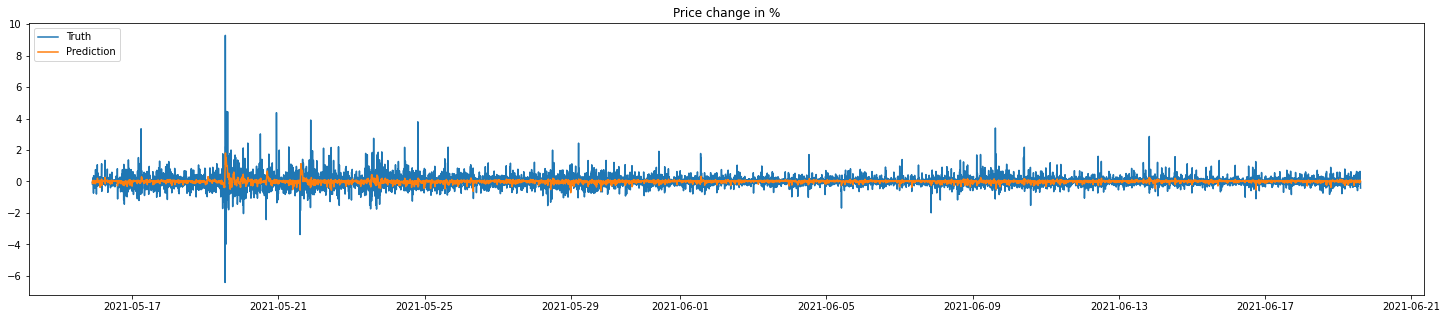

In [42]:
plt.figure(figsize=(25, 5))
plt.title("Price change in %")
plt.plot(eth_dates, y_true, label="Truth")
plt.plot(eth_dates, y_preds, label="Prediction")
plt.legend(loc="upper left")
plt.show()

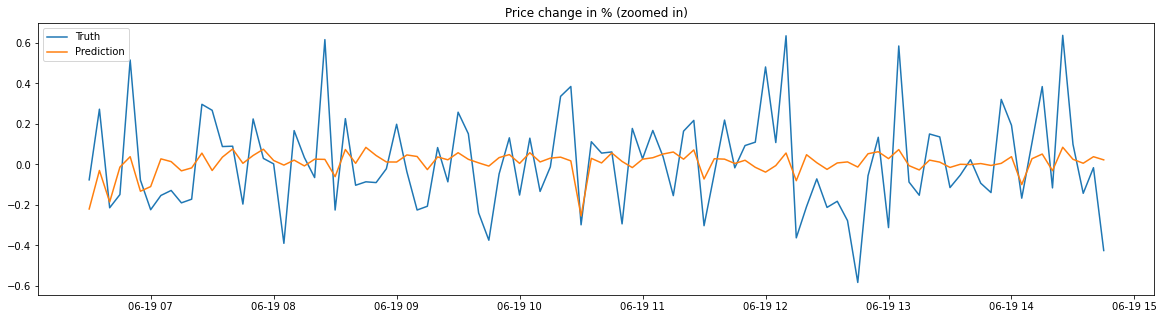

In [43]:
plt.figure(figsize=(20, 5))
plt.title("Price change in % (zoomed in)")
plt.plot(eth_dates[-100:], y_true[-100:], label="Truth")
plt.plot(eth_dates[-100:], (y_preds)[-100:], label="Prediction")
plt.legend(loc="upper left")
plt.show()

In [44]:
print("Predicted price changes bigger than 0.2%: {}/{}".
      format(len(y_preds[y_preds > 0.2]), len(y_preds)))

Predicted price changes bigger than 0.2%: 139/9996


In [45]:
print("True price changes bigger than 0.2%: {}/{}".
      format(len(y_true[y_true > 0.1]), len(y_true)))

True price changes bigger than 0.2%: 2922/9996


### Model that takes 2 channel input (ETH indicators + BTC indicators)
With a working model that predicts the change of ETH price given the ETH indicators, we wanted to see if introducing BTC indicators as a second channel (it's also a 15x15 grid) would improve the effectiveness of our net.

#### Downloading BTC indicators

In [46]:
url = 'https://drive.google.com/u/0/uc?id=1X-M5ASX0WRSF4xj0l2J7s1Z37XeTHbOT&export=download'
btc_eth_order = import_array('btc_5min_ethorder_100k.csv', gdown_ = True, gdown_path = url)

Downloading...
From: https://drive.google.com/u/0/uc?id=1X-M5ASX0WRSF4xj0l2J7s1Z37XeTHbOT&export=download
To: /content/btc_5min_ethorder_100k.csv
567MB [00:04, 128MB/s]


#### Scaling the data and preparing the data loader

In [47]:
# Calculating the sizes of train, valid and test sets
N = len(eth_x)
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1
train_size = int(train_frac * N)
valid_size = int(valid_frac * N + train_size)

y = targets_eth_x * 100
y = np.expand_dims(y, 1)
_train_X, _valid_X, _test_X = np.split(eth_x, [train_size, valid_size])
_train_X_btc, _valid_X_btc, _test_X_btc = np.split(btc_eth_order, [train_size, valid_size])
_train_y, _valid_y, _test_y = np.split(y, [train_size, valid_size])
_train_dates, _valid_dates, _test_dates = np.split(dates_as_np, [train_size, valid_size])

In [48]:
_train_X = reshape_for_scaling(_train_X)
_valid_X = reshape_for_scaling(_valid_X)
_test_X = reshape_for_scaling(_test_X)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X_train = scaler.fit_transform(_train_X)
scaled_X_valid = scaler.transform(_valid_X)
scaled_X_test = scaler.transform(_test_X)

_train_X = restore_og_shape(scaled_X_train, 15, 15)
_valid_X = restore_og_shape(scaled_X_valid, 15, 15)
_test_X = restore_og_shape(scaled_X_test, 15, 15)


_train_X_btc = reshape_for_scaling(_train_X_btc)
_valid_X_btc = reshape_for_scaling(_valid_X_btc)
_test_X_btc = reshape_for_scaling(_test_X_btc)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X_train_btc = scaler.fit_transform(_train_X_btc)
scaled_X_valid_btc = scaler.transform(_valid_X_btc)
scaled_X_test_btc = scaler.transform(_test_X_btc)

_train_X_btc = restore_og_shape(scaled_X_train_btc, 15, 15)
_valid_X_btc = restore_og_shape(scaled_X_valid_btc, 15, 15)
_test_X_btc = restore_og_shape(scaled_X_test_btc, 15, 15)

In [49]:
_train_X = compose_channels(list([_train_X, _train_X_btc]))
_valid_X = compose_channels(list([_valid_X, _valid_X_btc]))
_test_X = compose_channels(list([_test_X, _test_X_btc]))

In [50]:
batch_size = 1000
grid_loaders = {
    'train': DataLoader(batch_size, _train_X, _train_y, _train_dates, shuffle=True, device=device),
    'valid': DataLoader(batch_size, _valid_X, _valid_y, _valid_dates, shuffle=False, device=device),
    'test': DataLoader(batch_size, _test_X, _test_y, _test_dates, shuffle=False, device=device)
}

#### Training the model
We experimented with the same optimizing functions and parameters as with the 1 channel input. We also tried to expand the sizes of the network layers, but eventually the results were very similar to the results of network fed with 1 channel input. 

In [51]:
# eth_model = Conv2D(15, 15, conv_out=1600, no_channels=2, out1=32, out2=64, linear_out1=128)
# history = train(eth_model,
#             torch.optim.SGD(eth_model.parameters(), 
#                             lr=0.15, 
#                             momentum=0.9),
#             # torch.optim.Adam(eth_model.parameters(), lr=0.1),
#             grid_loaders,
#             max_num_epochs=300,
#             device='cuda',
#             early_stopping=25)
# plot_history(history)

#### Loading a pre-trained model

In [52]:
eth_model_url = 'https://drive.google.com/u/0/uc?id=1uUfQbbgiFzppkZWcVfC954w9tJdRkv1Y&export=download'

In [53]:
gdown.download(eth_model_url, "eth100k_08-01-01_1channel.pth", quiet=True)
model2d = Conv2D(15, 15, conv_out=1600, no_channels=2, out1=32, out2=64, linear_out1=128)
if device == 'cpu':
    model2d.load_state_dict(torch.load("eth100k_08-01-01_1channel.pth", map_location=torch.device('cpu')))
else:
    model2d.load_state_dict(torch.load("eth100k_08-01-01_1channel.pth"))

#### Evaluation


In [54]:
ic, _, _, y_preds, acc_pred_count = compute_loss(model2d, grid_loaders['test'])
_, y_true = grid_loaders['test'].get_all()
eth_dates = grid_loaders['test'].get_dates()
print("IC for test set: {:.2f}\nCorrectly predicted directions of changes in prices: {:.2f}%".format(ic, acc_pred_count * 100))

IC for test set: 0.19
Correctly predicted directions of changes in prices: 56.85%


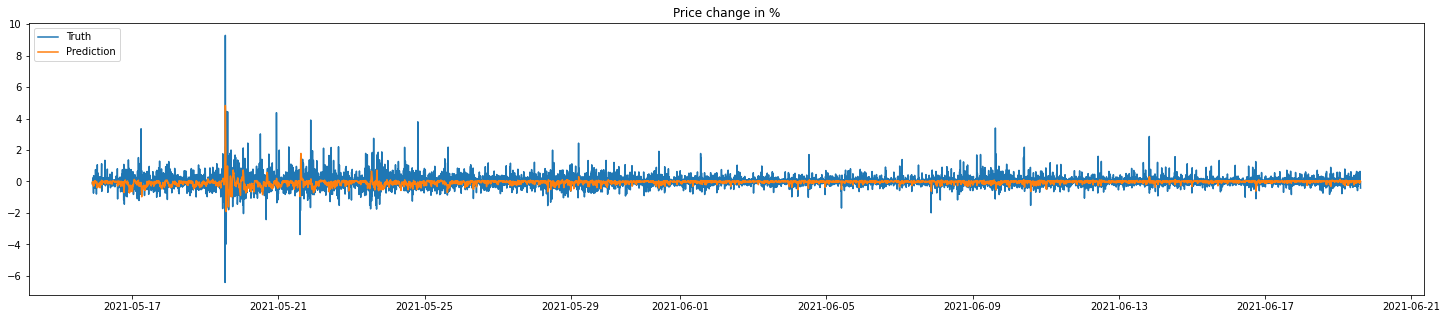

In [55]:
plt.figure(figsize=(25, 5))
plt.title("Price change in %")
plt.plot(eth_dates, y_true, label="Truth")
plt.plot(eth_dates, y_preds, label="Prediction")
plt.legend(loc="upper left")
plt.show()

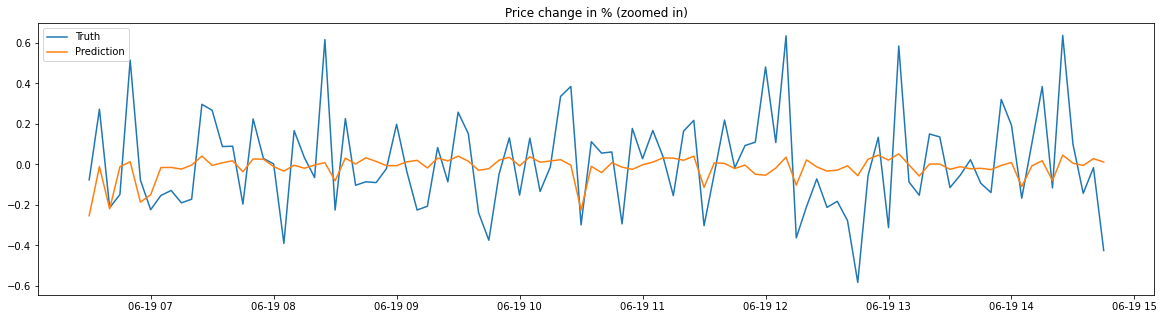

In [56]:
plt.figure(figsize=(20, 5))
plt.title("Price change in % (zoomed in)")
plt.plot(eth_dates[-100:], y_true[-100:], label="Truth")
plt.plot(eth_dates[-100:], (y_preds)[-100:], label="Prediction")
plt.legend(loc="upper left")
plt.show()

In [57]:
print("Predicted price changes bigger than 0.2%: {}/{}".
      format(len(y_preds[y_preds > 0.2]), len(y_preds)))

Predicted price changes bigger than 0.2%: 85/9996


# Backtesting a simple strategy 
We implement a simple trading strategy using the 2D ConvNet that was trained on 1 channel input of ETH indicators.

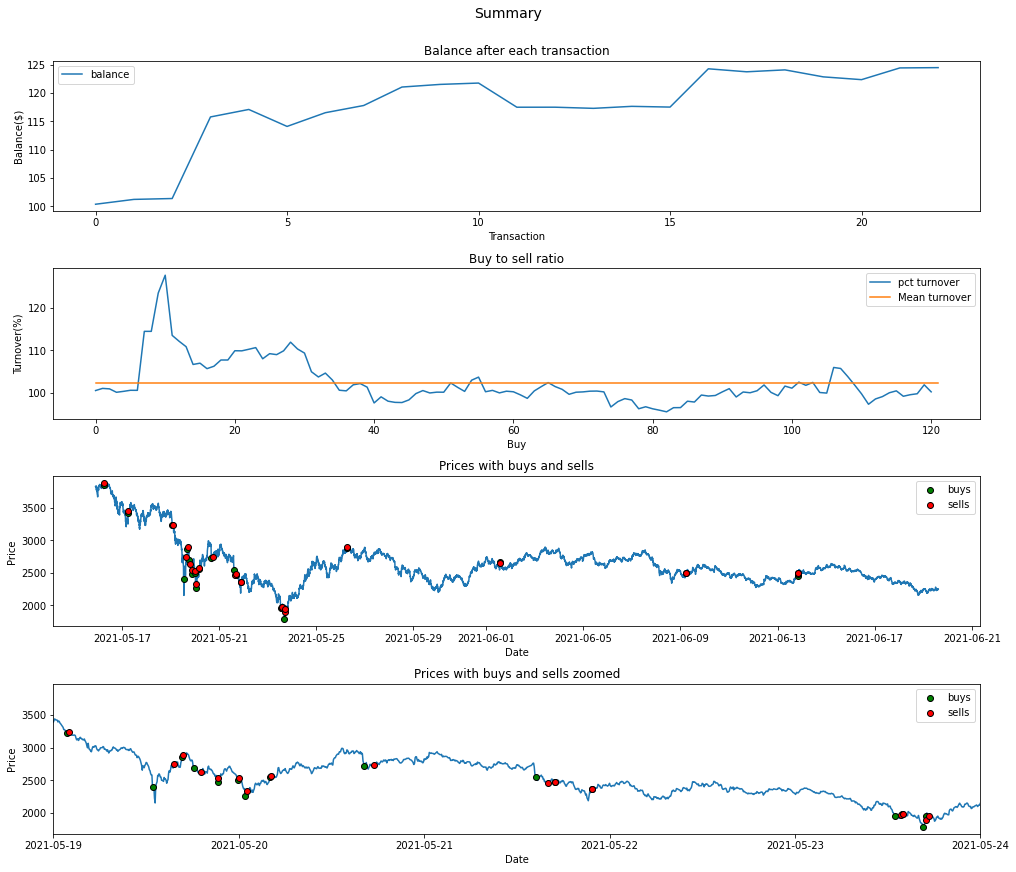

In [58]:
class AlphaTrader:
  def __init__(self, loaders, prices, model, budget):
    self.model = model
    self.prices = prices.drop(['vol', 'time', 'open', 'high', 'low'], axis=1)\
      .squeeze()
    self.samples = loaders['test'].get_all()[0]
    self.dates = loaders['test'].get_dates()
    self.balances = []
    self.sell_dates = []
    self.buy_dates = []
    self.trades_profits = []
    self.budget = budget
 
  def make_simulation(self, threshold):
    minute = 60000000000
    balance=self.budget
    vol=0
    trades = []
    for grid, date  in zip(self.samples, self.dates):
      predicted_change = float(self.model.forward(grid.unsqueeze(0)))
      current_price=self.prices.loc[date]
      if predicted_change > threshold:
        trades.append(current_price)
        if balance>0:
          self.buy_dates.append(date)
        vol+= (balance / current_price)*0.999
        #print('buy no. {}, buying {} btc, current balance is {}, and we hold {} btc'.format(len(trades) + len(self.trades_profits), (balance / current_price)*0.999, balance, vol))
        balance=0
        #self.balances.append(balance)
        
      elif vol>0:
        for price in trades:
          self.trades_profits.append((current_price/price) * 100)
        trades=[]
        self.sell_dates.append(date)
        balance += (vol * current_price)*0.999
        self.balances.append(balance)     
        #print('sell no. {}, selling {} btc, for {} dollars per btc, current balance is {}'.format(len(self.balances), vol,current_price, balance))
        vol = 0
    
    if vol>0:
        for price in trades:
          self.trades_profits.append((price/current_price - 1) * 100)
        trades=[]
        self.sell_dates.append(date)
        balance += (vol * current_price)*0.999
        #print('selling {} btc, for {} dollars per btc, current balance is {}'.format(current_price, vol, balance))
        vol = 0
        self.balances.append(balance)
 
  def plot_balances(self, left_lim, right_lim):
    fig, axs = plt.subplots(4, 1, constrained_layout=True)
    fig.suptitle('Summary', fontsize=14)
    fig.set_figheight(12)
    fig.set_figwidth(14)
    axs[0].plot(self.balances, label='balance')
    axs[0].set_title('Balance after each transaction')
    axs[0].set_xlabel('Transaction')
    axs[0].set_ylabel('Balance($)')
    leg = axs[0].legend()
 
    axs[1].plot(self.trades_profits, label='pct turnover')
    axs[1].plot([0, len(self.trades_profits)], [np.array(self.trades_profits).mean(),np.array(self.trades_profits).mean()], label='Mean turnover')
    axs[1].set_title('Buy to sell ratio')
    axs[1].set_xlabel('Buy')
    axs[1].set_ylabel('Turnover(%)')
    leg = axs[1].legend()
 
    axs[2].plot(self.dates, self.prices.loc[self.dates], zorder=-1)
    axs[2].scatter(self.buy_dates, self.prices.loc[self.buy_dates], c='green',edgecolors='black', label='buys', zorder=1)
    axs[2].scatter(self.sell_dates, self.prices.loc[self.sell_dates], c='red',edgecolors='black', label='sells', zorder=1)
    axs[2].set_title('Prices with buys and sells')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Price')
    leg = axs[2].legend()
 
 
    axs[3].set_xlim(left=left_lim,right=right_lim)
    axs[3].plot(self.dates, self.prices.loc[self.dates], zorder=-1)
    axs[3].scatter(self.buy_dates, self.prices.loc[self.buy_dates], c='green',edgecolors='black', label='buys', zorder=1)
    axs[3].scatter(self.sell_dates, self.prices.loc[self.sell_dates], c='red',edgecolors='black', label='sells', zorder=1)
    axs[3].set_title('Prices with buys and sells zoomed')
    axs[3].set_xlabel('Date')
    axs[3].set_ylabel('Price')
    leg = axs[3].legend()
 
 
eth_prices.index = pd.to_datetime(eth_prices.index)
Macio = AlphaTrader(grid_loaders_1channel, eth_prices, model2d_single_channel,100)
Macio.make_simulation(0.22)
 
Macio.plot_balances(np.datetime64('2021-05-19'),np.datetime64('2021-05-24'))

In [59]:
train_dates = grid_loaders_1channel['train'].get_dates()
print("Train set date range: {} - {}".format(train_dates[0], train_dates[-1]))
valid_dates = grid_loaders_1channel['valid'].get_dates()
print("Valid set date range: {} - {}".format(valid_dates[0], valid_dates[-1]))
test_dates = grid_loaders_1channel['test'].get_dates()
print("Test set date range: {} - {} (USED BY THE BOT)".format(test_dates[0], test_dates[-1]))

Train set date range: 2020-07-06T21:05:00.000000000 - 2021-04-10T21:35:00.000000000
Valid set date range: 2021-04-10T21:40:00.000000000 - 2021-05-15T21:45:00.000000000
Test set date range: 2021-05-15T21:50:00.000000000 - 2021-06-19T14:45:00.000000000 (USED BY THE BOT)


In [62]:
print(Macio.balances)

[100.34731561324676, 101.2015484902554, 101.35701701378845, 115.77669496034387, 117.09807079717113, 114.09974442770117, 116.52559364680614, 117.7971857759694, 121.0614189186743, 121.52917199276213, 121.76504698700015, 117.49509095956122, 117.49777949289661, 117.29614948353866, 117.64892839361079, 117.51886823344482, 124.28614157143346, 123.75654146899677, 124.09494193059561, 122.86111818528988, 122.36708265138245, 124.44128665538264, 124.49214861629788]


# Calculating indicators

In [60]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install -q Ta-Lib
%cd ..
clear_output(False)

In [61]:
class IndicatorsCreator:
    def __init__(self, 
                 df, 
                 T = list(range(6,21)), 
                 dim=15,
                 ):
       
        self.df = df
        self.T = T
        self.mi = {}
        self.mutual_info_df = pd.DataFrame()
        self.best_features = []
        self.mi_by_indicator = pd.DataFrame()
        self.dim = dim
        self.features = pd.DataFrame()
        self.features_order = []
        self.targets = pd.DataFrame()
        

    def compute_indicators(self):
      
        for t in tqdm(self.T):
            self.df[f'{t}_SMA'] = ta.SMA(self.df.close,timeperiod =t)
            self.df[f'{t}_EMA'] = ta.EMA(self.df['close'].values,t)
            self.df[f'{t}_WMA'] = ta.WMA(self.df['close'].values,t)
            self.df[f'{t}_RSI'] = ta.RSI(self.df['close'],t)
            self.df[f'{t}_WILLR'] = ta.WILLR(self.df.high, self.df.low, self.df.close, t)
            self.df[f'{t}_NATR'] = ta.NATR(self.df.high, self.df.low, self.df.close,t)
            self.df[f'{t}_CCI'] = ta.CCI(self.df.high, self.df.low, self.df.close,t)
            self.df[f'{t}_CMO'] = ta.CMO(np.asarray(self.df['close']), t)
            self.df[f'{t}_ROC'] = ta.ROC(self.df['close'],t)
            self.df[f'{t}_MOM'] = ta.MOM(self.df['close'],t)
            self.df[f'{t}_HIGHBB'], self.df[f'{t}_MIDBB'], self.df[f'{t}_LOWBB'] = ta.BBANDS(self.df.close, timeperiod= t, matype=0)
            self.df[f'{t}_ADOSC'] = ta.ADOSC(self.df.high, self.df.low, self.df.close,self.df.vol, fastperiod=t-3, slowperiod=t+4)
            self.df[f'{t}_ADX'] = ta.ADX(self.df.high, self.df.low, self.df.close, t)
            self.df[f'{t}_PPO'] = ta.PPO(self.df.close, fastperiod =t, matype = 1)
            self.df[f'{t}_APO'] = ta.APO(self.df.close, fastperiod=t, slowperiod = t+4, matype=0)
            self.df[f'{t}_KAMA'] = ta.KAMA(self.df.close,t)
            self.df[f'{t}_ATR'] = ta.ATR(self.df.high, self.df.low, self.df.close, t)
            self.df[f'{t}_DX'] = ta.DX(self.df.high, self.df.low, self.df.close, t)
            _, _,self.df[f'{t}_MACDHIST'] = ta.MACD(self.df.close)
            self.df[f'{t}_MFI'] = ta.MFI(self.df.high, self.df.low, self.df.close, self.df.vol, t)
        self.df = self.df.dropna()


    def compute_MI(self, T = [1,5], drop = True, plot = True):
        self.features = self.df.copy()

        if drop:
            self.features = self.features.drop(["close", "high", "vol", "low", "open"], axis=1)

        for t in tqdm(T):
            self.targets[f'r{t:02}'] = self.df['close'].pct_change(t)
            self.targets[f'r{t:02}_fwd'] = self.targets[f'r{t:02}'].shift(-t)
            
        for t in tqdm(T):
            target = f'r{t:02}_fwd'

            df = self.features.join(self.targets[target]).dropna()
            sample_start = int(np.round(0.6*len(df.index)- 50000))

            df = df.iloc[sample_start:(sample_start+50000)]
            X = df.drop(target, axis=1)
            y = df[target]
            self.mi[t] = pd.Series(mutual_info_regression(X=X, y=y),
                            index=X.columns).sort_values(ascending=False)
        self.mutual_info = pd.DataFrame(self.mi)
        self.mi_by_indicator = (self.mutual_info.groupby(self.mutual_info.index.to_series()
                                            .str.split('_').str[-1])
                        .mean()
                        .rank(ascending=False)
                        .sort_values(by=1))
        self.best_features = self.mi_by_indicator.head(self.dim).index
            

        if plot:
            self.plot_MI()

        self.features = pd.concat([self.features.filter(like=f'_{f}') for f in self.best_features], axis=1)

    
    def plot_MI(self):
        (self.mutual_info.groupby(self.mutual_info.index.to_series().str.split('_').str[-1])[1]
        .mean()
        .sort_values().plot.barh(title='Mutual Information with Forward Returns'))
        plt.tight_layout()

    def cluster_features(self,data, labels, ax, title):
        data = StandardScaler().fit_transform(data)
        pairwise_distance = pdist(data)
        Z = linkage(data, 'ward')
        c, coph_dists = cophenet(Z, pairwise_distance)
        dend = dendrogram(Z,
                        labels=labels,
                        orientation='top',
                        leaf_rotation=0.,
                        leaf_font_size=8.,
                        ax=ax)
        ax.set_title(title)
        return dend['ivl']

    def cluster(self):
        new_cols = {}
        for feature in tqdm(self.best_features):
            fnames = sorted(self.features.filter(like=f'_{feature}').columns.tolist())
            renamed = [f'{i:02}_{feature}' for i in range(1, len(fnames)+ 1)]
            new_cols.update(dict(zip(fnames, renamed)))
        self.features = self.features.rename(columns=new_cols).sort_index(1)

    def compute_grid(self, target = 'r01_fwd' , plot =True):
        '''Compute optimal col order and row order of dataframe'''

        fig, axes = plt.subplots(figsize=(15, 4), ncols=2)
        labels = sorted(self.best_features)
        title = 'Column Features: Indicators'

        col_order = self.cluster_features(self.features.dropna().values.reshape(-1, self.dim).T,
                                    labels,
                                    axes[0],
                                    title)
        labels = list(range(1, 16))
        
        title = 'Row Features: Indicator Parameters'
        row_order = self.cluster_features(
            self.features.dropna().values.reshape(-1, self.dim, self.dim).transpose((0, 2, 1)).reshape(-1, self.dim).T,
            labels, axes[1], title)
        
        self.feature_order = [f'{i:02}_{j}' for i in row_order for j in col_order]
        self.features = self.features.loc[:, self.feature_order]
        self.features = self.features.apply(pd.to_numeric, downcast='float')
    
    def get_numpy(self, t = 1, size=None):
        if size is None:
            size = len(self.best_features)

        outcome = f'r{t:02}_fwd'
        features = self.features.join(self.targets[outcome]).dropna()
        target = features[outcome]
        features = features.drop(outcome, axis=1)
        return features.to_numpy().reshape(-1,size, size), target.to_numpy()
    
    def run(self, plot = True):
        self.compute_indicators()
        self.compute_MI(plot = plot)
        self.cluster()
        self.compute_grid()
        return self.get_numpy()